**Install deepxde**  
Tensorflow and all other dependencies are already installed in Colab terminals

**Problem setup**  
  
We are going to solve the non-linear Schrödinger equation given by  
$i h_t + \frac{1}{2} h_{xx} + |h|^2h = 0$  
  
with periodic boundary conditions as  
$x \in [-5,5], \quad t \in [0, \pi/2]$  
$h(t, -5) = h(t,5)$  
$h_x(t, -5) = h_x(t,5)$  
  
and initial condition equal to  
$h(0,x) = 2 sech(x)$



Deepxde only uses real numbers, so we need to explicitly split the real and imaginary parts of the complex PDE.  
  
In place of the single residual  
$f = ih_t + \frac{1}{2} h_{xx} +|h|^2 h$  
  
we get the two (real valued) residuals  
$f_{\mathcal{R}} = u_t + \frac{1}{2} v_{xx} + (u^2 + v^2)v$  
$f_{\mathcal{I}} = v_t - \frac{1}{2} u_{xx} - (u^2 + v^2)u$  
  
where u(x,t) and v(x,t) denote respectively the real and the imaginary part of h.  


In [9]:
import numpy as np

import deepxde as dde

# For plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [22]:
x_lower = -10
x_upper = 10
t_lower = 0
t_upper = 8
T1 = t_upper - 4
# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

# The whole domain flattened
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Space and time domains/geometry (for the deepxde model)
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [23]:
# The "physics-informed" part of the loss


def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    u = y[:, 0:1]
    v = y[:, 1:2]

    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    return [f_u, f_v]

In [30]:
# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)

# Initial conditions
def init_cond_u(x):
    X = x  # 对应变量名保持一致

    a = 0.207141364073685
    # a = 0.769154559253350
    # a = 0.504585032803413

    b = np.sqrt(8 * a * (1 - 2 * a))
    w = 2 * np.sqrt(1 - 2 * a)

    A1 = 2 * (1 - 2 * a) * np.cosh(b * T1) + 1j * b * np.sinh(b * T1)
    A2 = np.sqrt(2 * a) * np.cos(w * X) - np.cosh(b * T1)

    u = np.exp(1j * T1) * (1 + A1 / A2)
    return u


def init_cond_v(x):
    return 0


ic_u = dde.PointSetBC(X_init, Y_init_u, component=0)
ic_v = dde.PointSetBC(X_init, Y_init_v, component=1)

In [31]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

# Network architecture
net = dde.nn.FNN([2] + [20] * 4 + [2], "tanh", "Glorot normal")

model = dde.Model(data, net)

Adam optimization.  

In [32]:
# To employ a GPU accelerated system is highly encouraged.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=10000, display_every=100)

Compiling model...
Building feed-forward neural network...
'build' took 0.031641 s



RuntimeError: IC function should return an array of shape N by 1 for each component.Use argument 'component' for different output components.

L-BFGS optimization.

In [7]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 0.247116 s

Training model...

1761      [7.96e-03, 9.86e-03, 9.85e-06, 1.84e-04, 5.30e-07, 7.93e-06, 1.87e-02, 1.79e-03]    [7.96e-03, 9.86e-03, 9.85e-06, 1.84e-04, 5.30e-07, 7.93e-06, 1.87e-02, 1.79e-03]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.038548
  Number of iterations: 1
  Number of functions evaluations: 27
1777      [7.96e-03, 9.86e-03, 9.85e-06, 1.84e-04, 5.30e-07, 7.93e-06, 1.87e-02, 1.79e-03]    [7.96e-03, 9.86e-03, 9.85e-06, 1.84e-04, 5.30e-07, 7.93e-06, 1.87e-02, 1.79e-03]    []  

Best model at step 1761:
  train loss: 3.85e-02
  test loss: 3.85e-02
  test metric: []

'train' took 0.859968 s



(<deepxde.model.LossHistory at 0x1b406c746d0>,
 <deepxde.model.TrainState at 0x1b406c74700>)

Final results.  
The reference solution and further information can be found in [this paper](https://arxiv.org/abs/1711.10561) from Raissi, Karniadakis, Perdikaris.  
The test data can be got [here](https://github.com/maziarraissi/PINNs/blob/master/main/Data/NLS.mat).

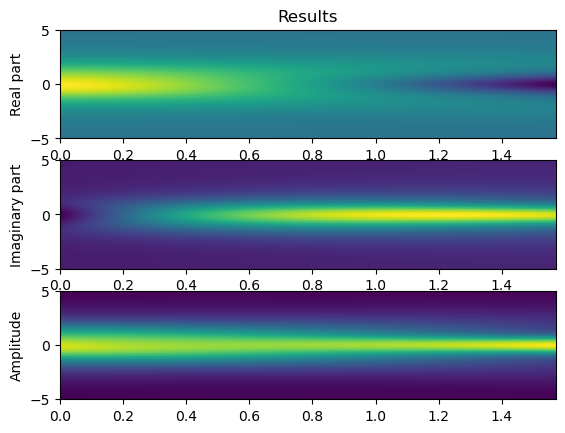

In [8]:
# Make prediction
prediction = model.predict(X_star, operator=None)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

h = np.sqrt(u ** 2 + v ** 2)


# Plot predictions
fig, ax = plt.subplots(3)

ax[0].set_title("Results")
ax[0].set_ylabel("Real part")
ax[0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part")
ax[1].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude")
ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.show()

**Assess the accuracy**

We can employ the test data to assess the accuracy of the trained model.  
Using the normalized $L^2$ norm defined as  
  
Error $u$ = $\frac{1}{||u_{test}||_{L^2}} ||u_{test} - u_{pred}||_{L^2}$  
  
where $u_{test}$ is the reference solution and $u_{pred}$ is the prediction given by the model, we get:  
  
Error $u$: 1.854433e-03  
Error $v$: 2.413796e-03  
Error $h$: 1.426797e-03  
  
We can also plot the absolute value of the error for each point of the domain. It's everywhere in the order E-3.  






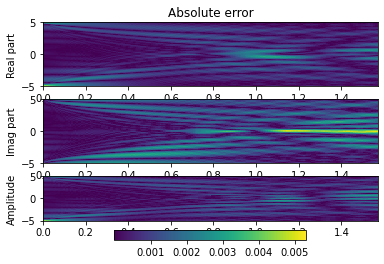